# 1.1 线性回归
介绍线性回归基本元素、矢量化加速、正态分布与平方损失、线性回归到深度网络

In [96]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [97]:
# 定义计时器
class Timer:
    def __init__(self):
        self.times = []
        self.start()
        self.tik = 0

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [98]:
# 定义正态分布
def normal(x, mu, sigma):
    p = 1 / (math.sqrt(2 * math.pi) * sigma)
    return p * np.exp(-0.5 / sigma ** 2 * (x - mu) ** 2)

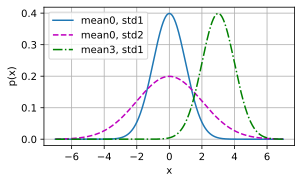

In [99]:
# 可视化正态分布
x = np.arange(-7, 7, 0.01)

# 均值与标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu,sigma in params], xlabel='x', ylabel='p(x)',
         figsize=(4.5, 2.5), legend=[f'mean{mu}, std{sigma}' for mu, sigma in params])

# 1.2 线性回归从零开始实现

In [2]:
import random
import torch
from d2l import torch as d2l

## 1.2.1 生成数据集
生成1000个样本的数据集，线性模型为：
$$
\mathbf{y} = \mathbf{Xw} + b + \epsilon
$$
$\mathbf{w}=[2,-3,4]\top$，$b = 4.2$，$\epsilon$为误差项，$\epsilon\sim\mathcal{N}(0, 0.01)$

In [3]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
num_data = 1000
features, labels = synthetic_data(true_w, true_b, num_data)

print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.1960, -0.0831]) 
label: tensor([4.8847])


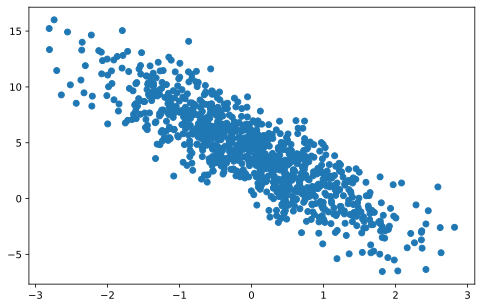

In [4]:
# 观察第二个特征与labels的散点图
d2l.set_figsize((8, 5))
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy())

## 1.2.2 读取数据集

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9110, -1.4552],
        [-1.1393,  0.4830],
        [ 0.7745, -0.2410],
        [ 0.4356,  2.0058],
        [ 0.1762, -0.7132],
        [ 0.4092,  0.4862],
        [-1.6769, -0.3953],
        [-1.1929, -0.0370],
        [ 0.1197, -0.1494],
        [ 0.7310, -1.3593]]) 
 tensor([[10.9724],
        [ 0.2866],
        [ 6.5435],
        [-1.7432],
        [ 6.9818],
        [ 3.3621],
        [ 2.1889],
        [ 1.9389],
        [ 4.9371],
        [10.2759]])


## 1.2.3 初始化模型参数

In [7]:
w = torch.normal(0, 0.01, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 1.2.4 定义模型

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 1.2.5 定义损失函数

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 1.2.6 定义优化算法

In [13]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 1.2.7 训练

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epochs {epoch + 1}, loss {float(train_l.mean()):f}')

epochs 1, loss 0.000050
epochs 2, loss 0.000050
epochs 3, loss 0.000050


In [16]:
with torch.no_grad():
    print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
    print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0001,  0.0007])
b的估计误差：tensor([-0.0002])
